# MaxCut - QAOA
I aim to solve the MaxCut problem using a Quantum Adiabatic Optimization Algorithm as defined here [https://arxiv.org/abs/1411.4028](https://arxiv.org/abs/1411.4028). A simple grid search over the parameter space will be used.

In [201]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cirq
import time

In [257]:
# number of vertices in the graph, the vertices are labelled from 0 to graph_size - 1
graph_size = 4
# list of edges [i,j] implies an edge between vertex i and vertex j
# this is simply a ring with vertices
edges = [[0,1],[1,2],[2,3],[3,0]]

In [239]:
def had(graph_size):
    '''
        Layer of H gates
    '''
    for j in range(graph_size):
        yield cirq.H(cirq.LineQubit(j))

def rot_B(graph_size,beta):
    '''
        Returns gate exp(-i beta sum_j sigma_X_j)
    '''
    gate = cirq.RotXGate(half_turns=beta)
    for j in range(graph_size):
        yield gate.on(cirq.LineQubit(j))

def rot_C(graph_size,edges,gamma):
    '''
        C_{ij} = 1/2*(1 + sigma_z_i sigma_z_j)
        Returns gates over all edges defined as exp(-i gamma sum_edges C_{ij})
        This exponentiation has a simple circuit decomposition, CNOT_{ij} RotZ(gamma/2) CNOT_{ij}
    '''
    for (i,j) in edges:
        gate_1 = cirq.CNOT(cirq.LineQubit(i),cirq.LineQubit(j))
        yield gate_1
        gate_2 = cirq.RotZGate(half_turns=gamma)
        yield gate_2.on(cirq.LineQubit(j))
        gate_3 = cirq.CNOT(cirq.LineQubit(i),cirq.LineQubit(j))
        yield gate_3

def calc_C(graph_size,edges):
    def func_C(measurements):
        # 'x' comes from the key for the measurement
        # convert True/False to 0,1
        meas_num = 1 - 2*np.array(measurements,dtype=np.int32)
        C = 0
        for (i,j) in edges:
            C += 0.5*(-meas_num[i]*meas_num[j] + 1)  
        return C
    return func_C

def obj_C(result):
    C_hist = result.histogram(key="x",fold_func=calc_C(graph_size,edges))
    return np.sum([k*v for k,v in C_hist.items()]) / result.repetitions

In [258]:
circuit = cirq.Circuit()
simulator = cirq.google.XmonSimulator()

qubits = [cirq.LineQubit(i) for i in range(graph_size)]

beta = 0.25
gamma = 0.5

# prepare uniform superposition of all states
circuit.append(had(graph_size))
# U(C,gamma) as defined in the paper
circuit.append(rot_C(graph_size,edges,gamma))
# U(B,beta) as defined in the paper
circuit.append(rot_B(graph_size,beta))
circuit.append(cirq.measure(*qubits, key='x'))
print(circuit)
result = simulator.run(circuit, repetitions=100)

C_hist = result.histogram(key="x",fold_func=calc_C(graph_size,edges))
print(C_hist)

print(obj_C(result))

0: ───H───@───────@───────────────────────────X───S───X───X^0.25───M('x')───
          │       │                           │       │            │
1: ───H───X───S───X───@───────@───────────────┼───────┼───X^0.25───M────────
                      │       │               │       │            │
2: ───H───────────────X───S───X───@───────@───┼───────┼───X^0.25───M────────
                                  │       │   │       │            │
3: ───H───────────────────────────X───S───X───@───────@───X^0.25───M────────
Counter({2.0: 43, 4.0: 34, 0.0: 23})
2.22


In [259]:
# manual sweep
num_points = 100
beta_linspace = np.linspace(0,1,num_points)
gamma_linspace = np.linspace(0,2,num_points)
C_arr = []
st = time.time()
for beta in beta_linspace:
    for gamma in gamma_linspace:
        circuit = cirq.Circuit()
        simulator = cirq.google.XmonSimulator()
        qubits = [cirq.LineQubit(i) for i in range(graph_size)]
        circuit.append(had(graph_size))
        circuit.append(rot_C(graph_size,edges,gamma))
        circuit.append(rot_B(graph_size,beta))
        circuit.append(cirq.measure(*qubits, key='x'))
        result = simulator.run(circuit, repetitions=100)
        C_arr.append(obj_C(result))
print("Completed in ",time.time()-st)

Completed in  712.4924328327179


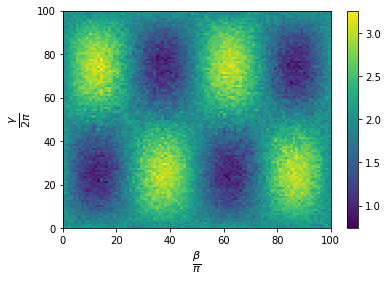

In [262]:
C_arr = np.array(C_arr).reshape(num_points,num_points)
plt.pcolor(C_arr)
plt.xlabel(r"$\frac{\beta}{\pi}$",fontsize=16)
plt.ylabel(r"$\frac{\gamma}{2\pi}$",fontsize=16)
plt.colorbar()

In [263]:
print("Max. estimated value of C",np.max(C_arr))

3.26


# Notes
The exact maximum value of C is 4 for the ring graph on 4 vertices (adjacent vertices have opposite values). The QAOA ansatz with 2 angles achives optimal values close to 3.3.